#  Predicting the max temperature for tomorrow - Random Forest Method

## Workflow

- Problem statement and loading data
- Data cleanup: Identify and correct missing data points/anomalies as required
- Data preparation for machine learning
- Create baseline model
- Train the model on the training data
- Perfrom validation with test data
- Evaluate performance matrics
- Try different methods and compare the models
- Report

### Data

The temperatures are fro Seattle, WA from 2016 using the NOAA Climate Data Online tool.

There are other sources for the data
[Dark Sky API](https://darksky.net/dev/docs/sources)

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
Tempdata = pd.read_csv('Temp_data.csv')

In [3]:
Tempdata.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [4]:
Tempdata.columns = ['year', 'month', 'day', 'week', 'temp_2dayprior', 'temp_1dayprior', 'average', 'actual',
       'forecast_noaa', 'forecast_acc', 'forecast_under', 'friend']

In [5]:
# shape of the features
Tempdata.shape

(348, 12)

In [6]:
# stat of the data
Tempdata.describe()

,year,month,day,temp_2dayprior,temp_1dayprior,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


#### Gridspec
We use the [gridspec](https://matplotlib.org/users/gridspec.html) for ploting.

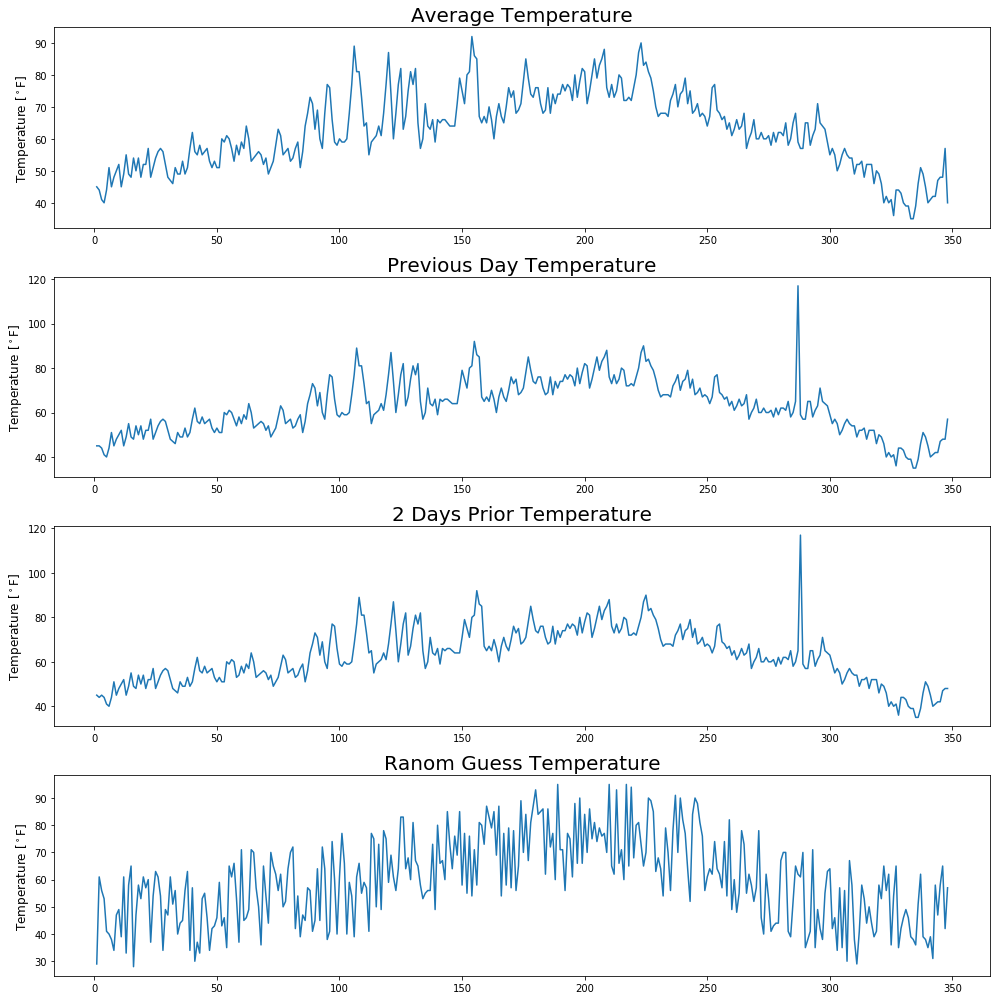

In [7]:
fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(14,14))

xday = np.arange(1,len(Tempdata)+1)  
ax[0].plot(xday, Tempdata['actual']); ax[0].set_title('Average Temperature', fontsize=20);
ax[0].set_ylabel('Temperature [$^\circ$F]', fontsize=12);

ax[1].plot(xday, Tempdata['temp_1dayprior']); ax[1].set_title('Previous Day Temperature', fontsize=20);
ax[1].set_ylabel('Temperature [$^\circ$F]', fontsize=12);

ax[2].plot(xday, Tempdata['temp_2dayprior']); ax[2].set_title('2 Days Prior Temperature', fontsize=20);
ax[2].set_ylabel('Temperature [$^\circ$F]', fontsize=12);

ax[3].plot(xday, Tempdata['friend']); ax[3].set_title('Ranom Guess Temperature', fontsize=20);
ax[3].set_ylabel('Temperature [$^\circ$F]', fontsize=12);
plt.tight_layout()

#### One-Hot Encoding
By far the most common way to represent categorical variables is using the one-hot- encoding or one-out-of-N encoding, also known as dummy variables. The idea behind dummy variables is to replace a categorical variable with one or more new features that can have the values 0 and 1. The values 0 and 1 make sense in the formula for linear binary classification (and for all other models in scikit-learn), and we can represent any number of categories by introducing one new feature per category, as described here.

Let’s say for the workclass feature we have possible values of "Government Employee", "Private Employee", "Self Employed", and "Self Employed Incorpo rated". To encode these four possible values, we create four new features, called "Gov ernment Employee", "Private Employee", "Self Employed", and "Self Employed Incorporated". A feature is 1 if workclass for this person has the corresponding value and 0 otherwise, so exactly one of the four new features will be 1 for each data point. This is why this is called one-hot or one-out-of-N encoding.

Using pandas's get_dummies, we perform one hot coding on the week day.

In [8]:
Tempdata = pd.get_dummies(Tempdata)
Tempdata.head()

,year,month,day,temp_2dayprior,temp_1dayprior,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


In [9]:
# target

target = np.array(Tempdata['actual'])

In [10]:
# drop the target labels

Tempdata = Tempdata.drop(['actual', 'forecast_noaa', 'forecast_acc', 'forecast_under'],
                         axis = 1)

In [11]:
features_list = list(Tempdata.columns)

In [12]:
features = np.array(Tempdata)

### Training and Testing Sets

In [13]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (233, 14)
Training Labels Shape: (233,)
Testing Features Shape: (115, 14)
Testing Labels Shape: (115,)


In [14]:
# The baseline predictions are the historical averages
baseline_preds = X_test[:, features_list.index('average')]

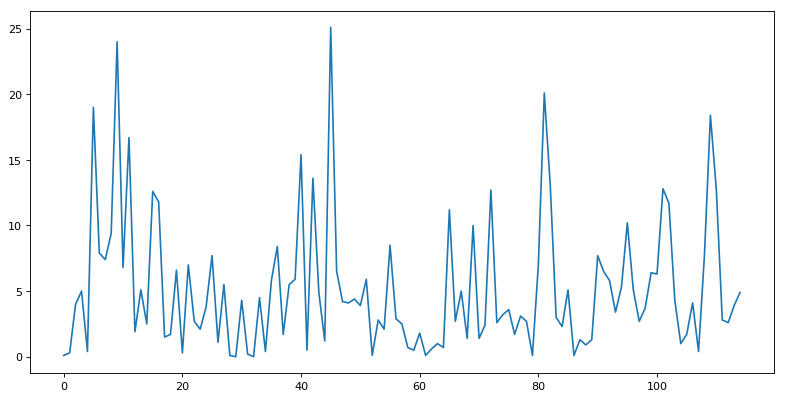

In [15]:
error_baseline = abs(baseline_preds-y_test)
plt.figure(figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(0, len(baseline_preds)),abs(baseline_preds-y_test))

In [16]:
# Statistics of the data
print('Average baseline error: ', round(np.mean(error_baseline), 2))

Average baseline error:  5.18


In [17]:
#Train Model

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

### Prediction using the trained model

In [18]:
# Use the forest's predict method on the test data
predictions_rf_c = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions_rf_c - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.87 degrees.


#### Explained variance score
Let's compute [explained variation](https://en.wikipedia.org/wiki/Explained_variation)

In [19]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, predictions_rf_c, multioutput='uniform_average')

0.84759753359277401

#### Mean Absolute Error

In [20]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predictions_rf_c, multioutput='uniform_average')

3.8688434782608696

#### R² score, the coefficient of determination

In [21]:
from sklearn.metrics import r2_score
r2_score_cd = r2_score(y_test, predictions_rf_c, multioutput='uniform_average')
r2_score_cd

0.83669588955823293

In [59]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error_rf_c = mean_absolute_error(y_test, predictions_rf_c)

mean_absolute_error_rf_c

3.8688434782608696

## Visualize one of the trees

In [22]:
import graphviz
from sklearn import tree

tree1 = rf.estimators_[5] 
dot_data = tree.export_graphviz(tree1, out_file=None, feature_names = features_list, rounded = True, precision = 1) 
graph = graphviz.Source(dot_data) 
graph.render('tree1')

'tree1.pdf'

## Feature Importance

In [23]:
importances = list(rf.feature_importances_)

In [24]:
feat_importances = [(feat, round(importance, 2)) for feat, importance in 
                   zip(features_list, importances)]

In [25]:
[print('Variable: {:20} Importance: {}'.format(*pair)) 
 for pair in feat_importances];

Variable: year                 Importance: 0.0
Variable: month                Importance: 0.01
Variable: day                  Importance: 0.02
Variable: temp_2dayprior       Importance: 0.03
Variable: temp_1dayprior       Importance: 0.64
Variable: average              Importance: 0.25
Variable: friend               Importance: 0.03
Variable: week_Fri             Importance: 0.01
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


## Model with only important features

In [26]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

In [27]:
# Extract the two most important features
important_indices = [features_list.index('temp_1dayprior'), 
                     features_list.index('average')]

In [28]:
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]

In [29]:
# Train the random forest
rf_most_important.fit(train_important, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [30]:
# Make predictions and determine the error
predictions_rf = rf_most_important.predict(test_important)

In [31]:
errors = abs(predictions_rf - y_test)

In [32]:
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.94 degrees.


In [33]:
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.78 %.


In [34]:
r2_score_imp = r2_score(predictions_rf, y_test)
r2_score_imp

0.76371493301920768

In [60]:
mean_absolute_error_rf = mean_absolute_error(y_test, predictions_rf)

mean_absolute_error_rf

3.9392334886128371

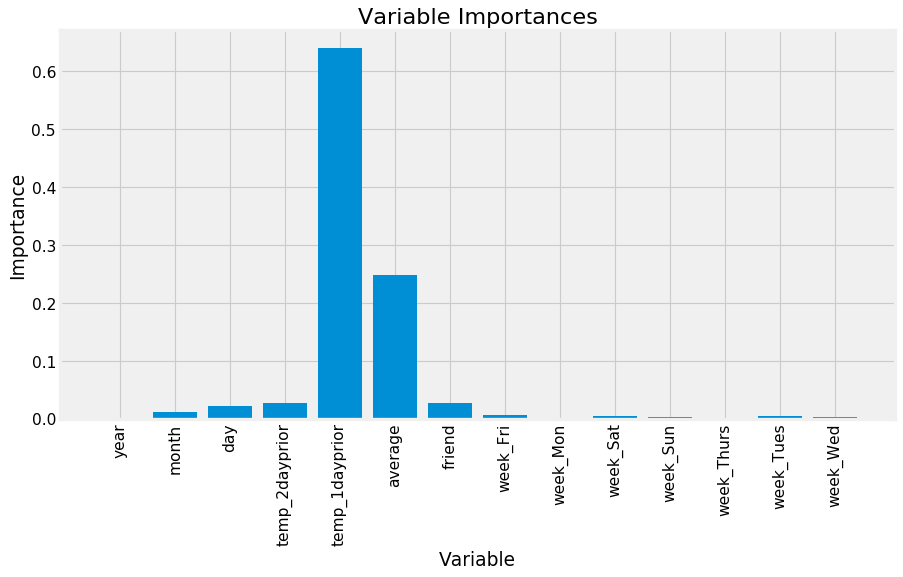

In [35]:
# Set the style
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Forecasting

In [36]:
# Create date time objects for plotting
import datetime

# Dates of training
months = X_train[:, features_list.index('month')]
days = X_train[:, features_list.index('day')]
years = X_train[:, features_list.index('year')]

In [37]:
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) 
         for year, month, day in zip(years, months, days)]

In [38]:
train_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [39]:
# Dates of test date
months = X_test[:, features_list.index('month')]
days = X_test[:, features_list.index('day')]
years = X_test[:, features_list.index('year')]

dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) 
         for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]


In [40]:
# All date and data:
months = Tempdata['month']
days = Tempdata['day']
years = Tempdata['year']

dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) 
         for year, month, day in zip(years, months, days)]
all_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [41]:
# dataframe for predictions and dates

predict_data = pd.DataFrame(data = {'date': test_dates,
                                   'prediction': predictions_rf})

<function matplotlib.pyplot.tight_layout>

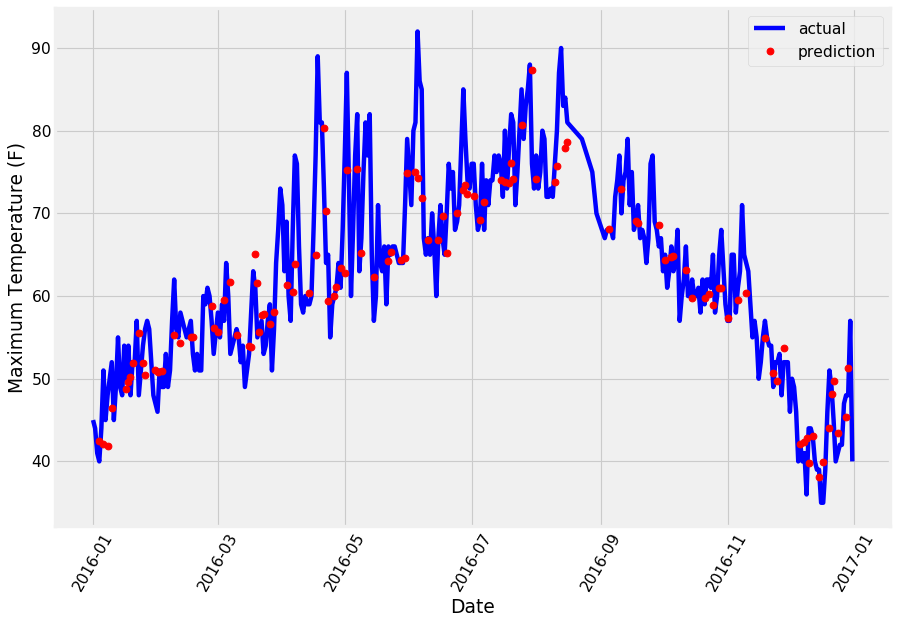

In [42]:
# plot the actual values
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(all_dates, target, 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predict_data['date'], predict_data['prediction'], 
         'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); 
plt.tight_layout

In [43]:
# distribution of errors

error = (predictions_rf - y_test)

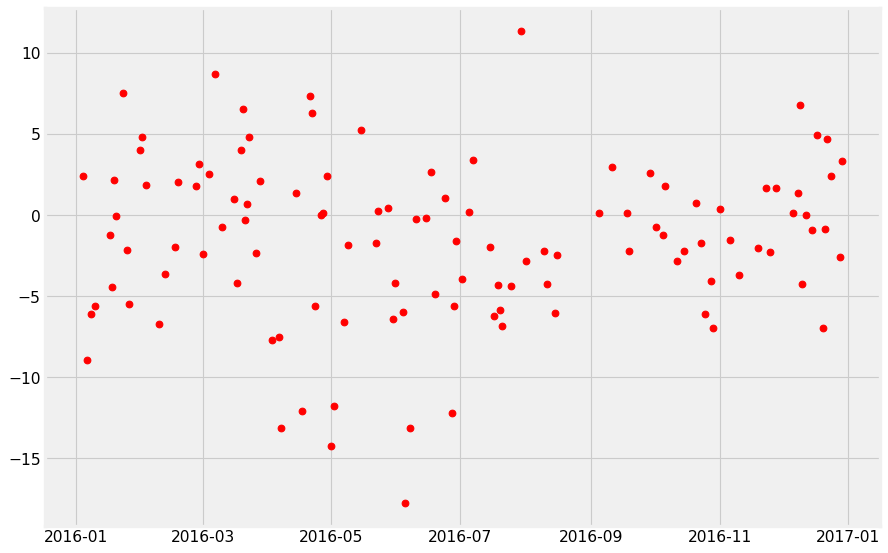

In [44]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_dates, error, 'ro', label = 'Error')

(array([  1.,   5.,   1.,  12.,  19.,  26.,  32.,  12.,   5.,   2.]),
 array([-17.722 , -14.8151, -11.9082,  -9.0013,  -6.0944,  -3.1875,
         -0.2806,   2.6263,   5.5332,   8.4401,  11.347 ]),
 <a list of 10 Patch objects>)

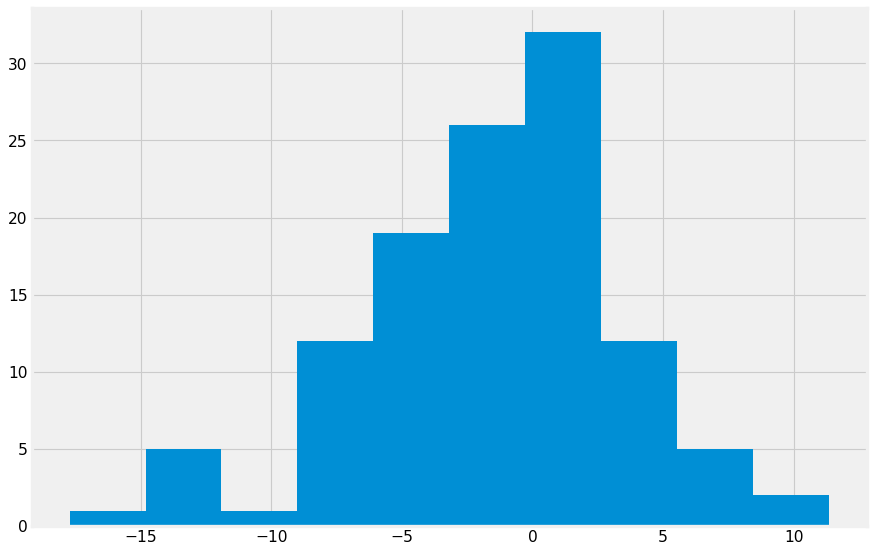

In [45]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.hist(error)

In [46]:
Tempdata.head()


,year,month,day,temp_2dayprior,temp_1dayprior,average,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,41,0,0,0,0,0,1,0


In [47]:
originalsignal = pd.DataFrame(data={'date':all_dates,
                                   'actual': target})
originalsignal.index = pd.to_datetime(originalsignal.date)
originalsignal.drop('date',axis=1, inplace=True)
originalsignal.head()

,actual
date,
2016-01-01,45
2016-01-02,44
2016-01-03,41
2016-01-04,40
2016-01-05,44


In [48]:
lowpasssignal= originalsignal.resample("1D").ffill().rolling(window=7, min_periods=1).mean()

lowpasssignal.columns = ['Filtered Temp']

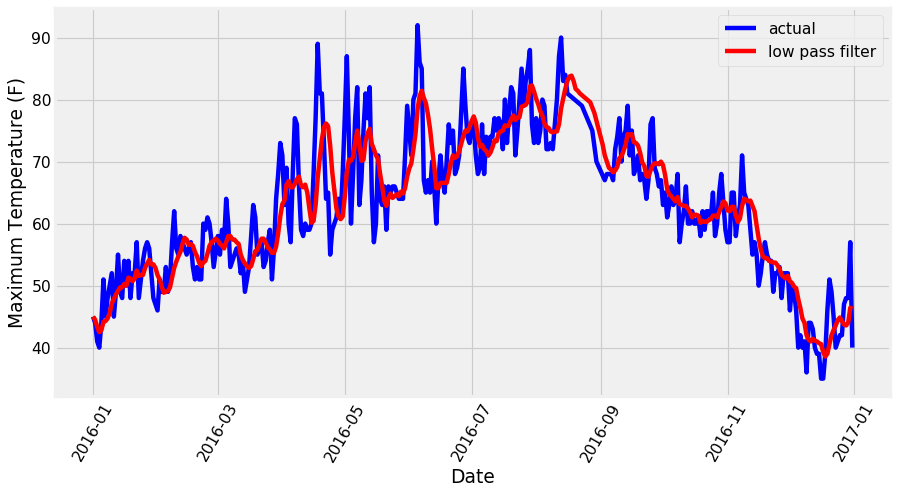

In [49]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(all_dates, target, 'b-', label = 'actual')

# Plot the low pas filter
plt.plot(lowpasssignal.index, lowpasssignal['Filtered Temp'], 'r-', label = 'low pass filter')
plt.xticks(rotation = '60'); 
plt.legend()

plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); 
# plt.tight_layout

<function matplotlib.pyplot.tight_layout>

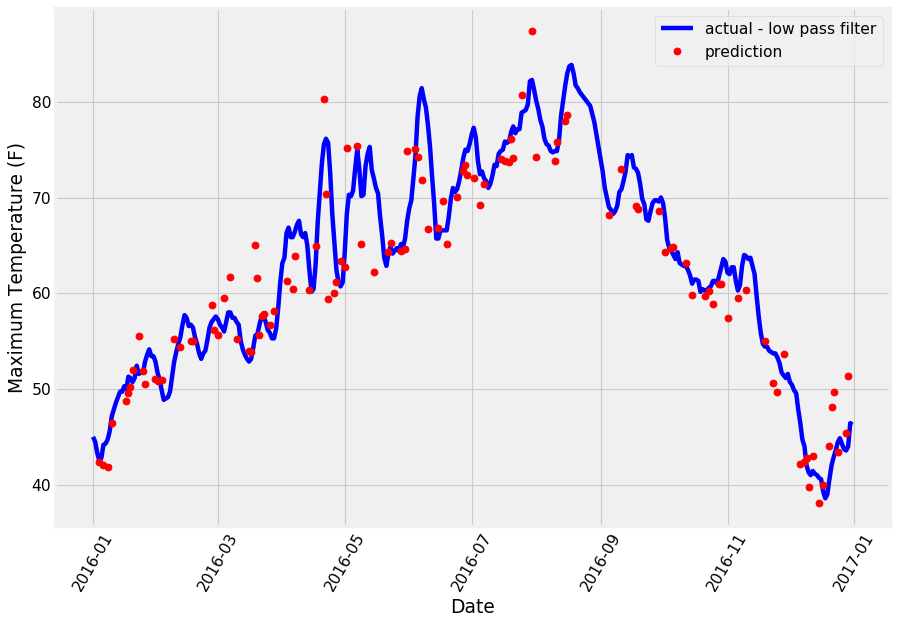

In [50]:
# plot the low pass filter
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(lowpasssignal.index, lowpasssignal['Filtered Temp'], 'b-', label = 'actual - low pass filter')

# Plot the predicted values
plt.plot(predict_data['date'], predict_data['prediction'], 
         'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); 
plt.tight_layout

In [51]:
! pip install xgboost

In [52]:
! pip install --upgrade pip

Requirement already up-to-date: pip in /Users/zoha/.Envs/DS_BCamp/lib/python3.6/site-packages (10.0.1)


In [53]:
from xgboost import XGBRegressor

In [54]:
# fit model on training data
xgbm = XGBRegressor()
xgbm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [55]:
# Make predictions and determine the error
predict_xgb = xgbm.predict(X_test)

r2_score_xgb = r2_score(predict_xgb, y_test)
r2_score_xgb

0.80132157071096699

In [57]:
mean_absolute_error_xgb= mean_absolute_error(predict_xgb, y_test)
mean_absolute_error_xgb

3.8263793613599693

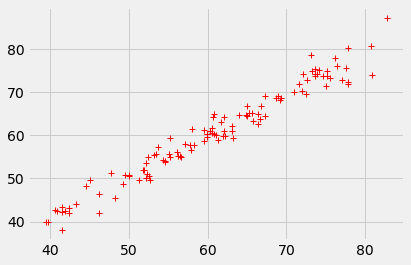

In [64]:
plt.plot(predict_xgb, predictions_rf, 'r+')